In [77]:
import os
import cv2
import os
import numpy as np
import torch
import sys
import matplotlib.pyplot as plt
from scipy.fftpack import fft, fftshift
sys.path.insert(0, os.path.abspath(os.path.join(os.path.dirname(__vsc_ipynb_file__), '../../')))
from gestures.configs import new_config as cfg1
from gestures.data_loader1.load import get_data_loader

# from gestures.data_loader.tiny_data_loader import get_tiny_data_loader
from gestures.network.experiment_tracker import get_time_in_string
from gestures.network.runner import Runner
from gestures.setup import setup_callbacks, setup_model
from gestures.utils_preprocessing import ComplexToReal, DownSampleOffLine, Normalize, ToTensor



data_config = cfg1.data_config
main_config = cfg1.main_config
data_dir, output_dir, device = (
    main_config["data_dir"],
    main_config["output_dir"],
    main_config["device"],
)

# loop for different ds factors
extra_info = "not_norm_doppler"

data_loaders = get_data_loader(
    data_dir=main_config["data_dir"],
    task=main_config["task"],
    loader_cfg=cfg1.data_loader,
    processing_func=cfg1.pr_funcs,
    ds_factor=1
)

In [124]:
def plot_doppler(x, comp=True):
    plt.rcdefaults()
    if not comp:
        x = x[0] + 1j * x[1]
    x = np.abs(x)
    x = torch.Tensor(x)
    x = torch.abs(torch.fft.fftshift(torch.fft.fft(x, dim=0), dim=0))
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.imshow(x.cpu().numpy())
    # plt.xlabel("Slow Time")
    # plt.ylabel("Fast Time")
    plt.show()

def down_sample_img(
    x: np.ndarray, row_factor: int, col_factor: int, original_dim: bool = False
) -> np.ndarray:
    def _down_sample(img: np.ndarray, row_factor: int, col_factor: int) -> np.ndarray:
        return img[:,::row_factor, ::col_factor]

    def _up_scale(img: np.ndarray, dim_up: tuple[int, int]) -> np.ndarray:
        if img.dtype == np.complex64:
            real_img = np.real(img)
            imag_img = np.imag(img)
            data_real_up = cv2.resize(real_img, dim_up, interpolation=cv2.INTER_CUBIC)
            data_imag_up = cv2.resize(imag_img, dim_up, interpolation=cv2.INTER_CUBIC)
            return data_real_up + 1j * data_imag_up
        else:
            return cv2.resize(img, dim_up, interpolation=cv2.INTER_CUBIC)

    org_dim = (x.shape[1], x.shape[0])
    img = _down_sample(x, row_factor, col_factor)
    if original_dim:
        img = _up_scale(img, org_dim)

    return img

down_sample2 = DownSampleOffLine(2)
down_sample4 = DownSampleOffLine(4)
down_sample8 = DownSampleOffLine(8)

In [125]:
model_path = "/Users/netanelblumenfeld/Desktop/bgu/Msc/code/outputs1/sr_classifier/sr_SAFMN_classifier_TinyRadar_sr_loss_L1_classifier_loss_TinyLoss/ds_4_original_dim_False_not_norm_doppler/2024-05-04_18:29:45/model/total_loss.pth"
    # getting model
model_cls, optimizer, acc, loss_metric = setup_model(
        task=main_config["task"],
        model_cfg=cfg1.model_config,
        device=device,
    )
model, _, _, _ = model_cls.load_model(device, model_path)

In [126]:
for x,y in data_loaders["test"]:
    break
y[0].shape

torch.Size([20, 5, 2, 2, 32, 492])

In [119]:
sr_imgs = y[0]
lr_imgs2 = down_sample2(sr_imgs)
lr_imgs4 = down_sample4(sr_imgs)
lr_imgs8 = down_sample8(sr_imgs)


In [127]:
outs = model(lr_imgs4)
rec_imgs = outs[0].reshape(
            5,
            20,
            2,
            2,
            32,
            492,
        )

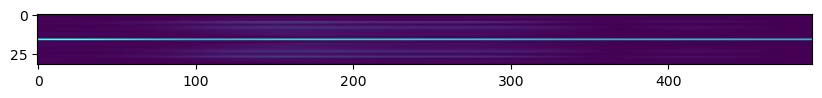

In [120]:
k=9
sr = y[0][k,2,1]
plot_doppler(sr, comp=False)


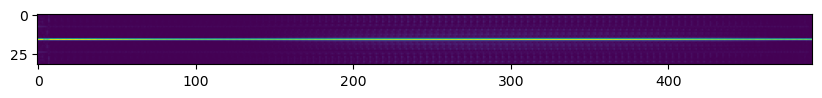

In [128]:
plot_doppler(rec_imgs[2,9,1].detach().numpy(), comp=False)

In [145]:
rec_imgs.shape

torch.Size([5, 20, 2, 2, 32, 492])

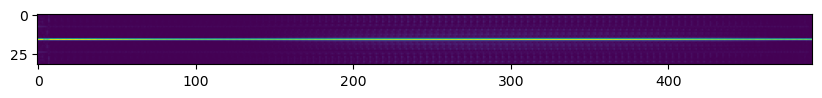

In [146]:
plot_doppler(rec_imgs[2,9,1].detach().numpy(), comp=False)

In [41]:
sr_img = sr.numpy()
sr_img = sr_img[0] + 1j * sr_img[1]
hrb_img4 = down_sample_img(sr_img, 4, 4, original_dim=True)
lr_img4 = down_sample_img(sr_img, 4, 4)
lr_img8 = down_sample_img(sr_img, 8, 8)
hrb_img8 = down_sample_img(sr_img, 8, 8, original_dim=True)
hrb_img2 = down_sample_img(sr_img, 2, 2, original_dim=True)
lr_img2 = down_sample_img(sr_img, 2, 2)

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

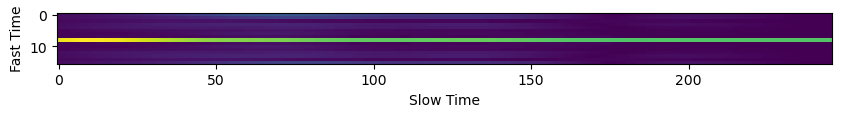

In [91]:
plot_doppler(lr_img2)

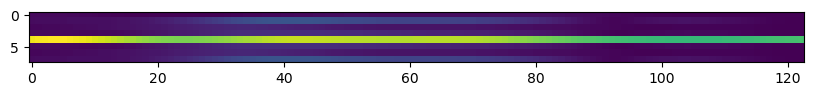

In [122]:
plot_doppler(lr_imgs4[k,2,1], comp=False)
